newyork taxt data analysis: https://github.com/swapnanilsharma/Taxi-demand-prediction-in-New-York-City/blob/master/NYC%20Final.ipynb

In [2]:
import matplotlib.pyplot as plt
import dask.dataframe as dd#similar to pandas
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix 
import numpy as np
import seaborn as sns#Plots

In [3]:
# 데이터 열기
pd.set_option('display.max_columns', None)

month = pd.read_parquet('yellow_tripdata_2018-01.parquet',engine='pyarrow')

print(month)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1               1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2               1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3               1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4               1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   
...           ...                  ...                   ...              ...   
8760682         1  2018-01-31 23:21:35   2018-01-31 23:34:20                2   
8760683         1  2018-01-31 23:35:51   2018-01-31 23:38:57                1   
8760684         2  2018-01-31 23:28:00   2018-01-31 23:37:09                1   
8760685         2  2018-01-31 23:24:40   2018-01-31 23:25:28                1   
8760686         2  2018-01-31 23:28:16   2018-01-31 23:28:38                1   

         trip_distance  Rat

In [4]:
# 널값 아닌 데이터 수
month.notnull().sum()

VendorID                 8760687
tpep_pickup_datetime     8760687
tpep_dropoff_datetime    8760687
passenger_count          8760687
trip_distance            8760687
RatecodeID               8760687
store_and_fwd_flag       8760687
PULocationID             8760687
DOLocationID             8760687
payment_type             8760687
fare_amount              8760687
extra                    8760687
mta_tax                  8760687
tip_amount               8760687
tolls_amount             8760687
improvement_surcharge    8760687
total_amount             8760687
congestion_surcharge          12
airport_fee                   12
dtype: int64

In [7]:
print(month.shape)

(8760687, 19)


In [13]:
# 상위 값 5개
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,NaN
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,NaN,NaN
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,NaN,NaN
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,NaN,NaN
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,NaN,NaN


1. time

In [157]:
# def convert_to_unix(s):

#     return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    
def return_with_trip_times(month):
    # 탑승, 하차 시간 가져오기
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    # unix time으로 변환
    duration_pickup = [x for x in duration['tpep_pickup_datetime'].values]
    duration_dropoff = [x for x in duration['tpep_dropoff_datetime'].values]
    
    # 이동 시간(분)
    onemin = pd.Timedelta(minutes=1)
    durations = (np.array(duration_dropoff) - np.array(duration_pickup)) / onemin
    #print(durations)

    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID', 'total_amount', 'tip_amount']]

    # 이동 시간과 이동 속도를 담은 새 데이터 생성    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    # /hour로 변환
    new_frame['speed'] = 60 * (new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(month)


C:\Users\sktmd\AppData\Local\Temp\ipykernel_11568\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_11568\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_11568\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

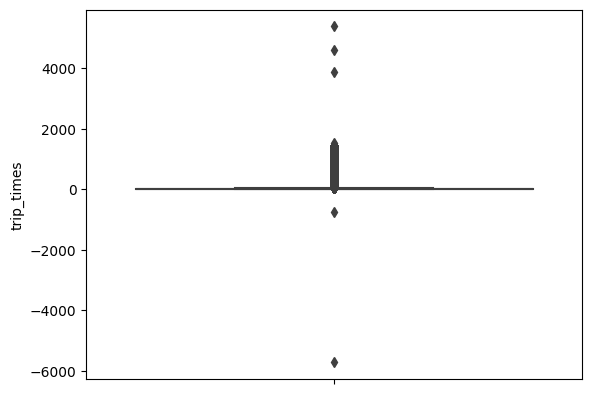

In [37]:
# 분단위
sns.boxplot(y="trip_times", data=frame_with_durations)
plt.show()

In [62]:
# 10%마다 해당되는 시간
for i in range(0, 100, 10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])
# 양 끝쪽에 튀는 데이터 존재

0 percentile value is -5711.583333333333
10 percentile value is 3.8833333333333333
20 percentile value is 5.483333333333333
30 percentile value is 7.0
40 percentile value is 8.6
50 percentile value is 10.366666666666667
60 percentile value is 12.466666666666667
70 percentile value is 15.133333333333333
80 percentile value is 18.933333333333334
90 percentile value is 25.683333333333334
100 percentile value id  5382.066666666667


In [63]:
# 90%~100%마다 해당되는 시간
for i in range(90, 100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])

90 percentile value is 25.683333333333334
91 percentile value is 26.75
92 percentile value is 27.95
93 percentile value is 29.366666666666667
94 percentile value is 31.016666666666666
95 percentile value is 33.03333333333333
96 percentile value is 35.6
97 percentile value is 39.083333333333336
98 percentile value is 44.416666666666664
99 percentile value is 54.46666666666667
100 percentile value id  5382.066666666667


In [71]:
# 0%~10%마다 해당되는 시간
for i in range(0, 11):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

0 percentile value is -5711.583333333333
1 percentile value is 1.1833333333333333
2 percentile value is 1.8666666666666667
3 percentile value is 2.283333333333333
4 percentile value is 2.5833333333333335
5 percentile value is 2.85
6 percentile value is 3.0833333333333335
7 percentile value is 3.3
8 percentile value is 3.5
9 percentile value is 3.7
10 percentile value is 3.8833333333333333


In [162]:
# 시간이 이상하게 튀는 값 삭제(12시간까지) -> 더 줄여도될듯?
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<120)]
print(frame_with_durations_modified.shape)

(8669825, 9)


In [122]:
var = frame_with_durations_modified["trip_times"].values
var = np.sort(var, axis=None)
print(var[0], var[-1])

1.0166666666666666 719.2166666666667


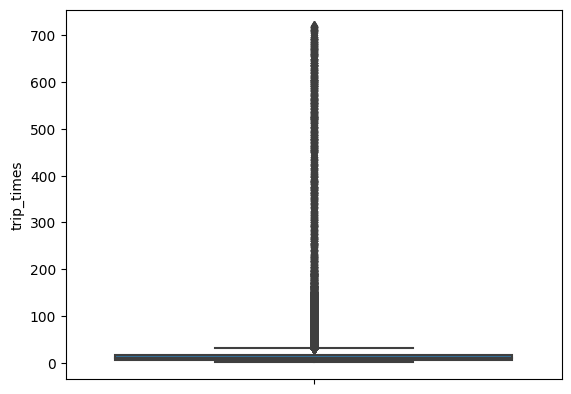

In [124]:
sns.boxplot(y="trip_times", data=frame_with_durations_modified)
plt.show()
# 왜 최댓값 30대???
# -> 1사분위수, 3사분위수에서 상자 길이의 1.5배 떨어진 거리가 최소, 최대값을 의미

c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


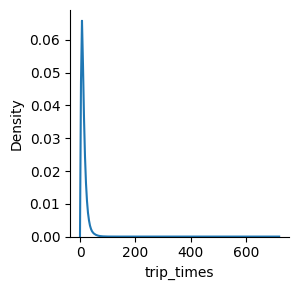

In [125]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "trip_times") \
    .add_legend()
plt.show()

In [137]:
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


C:\Users\sktmd\AppData\Local\Temp\ipykernel_11568\2641135077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


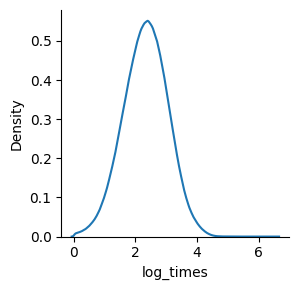

In [138]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "log_times") \
    .add_legend()
plt.show()

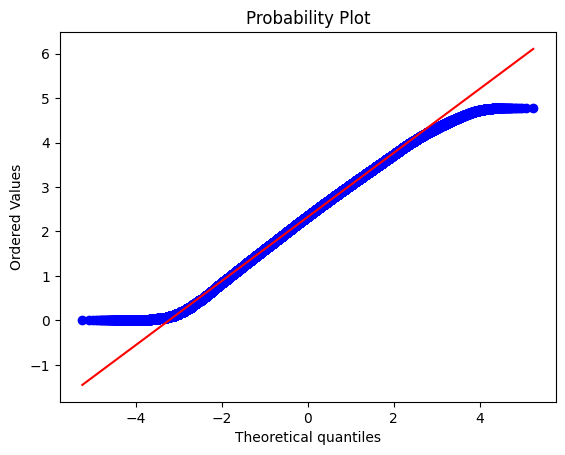

In [135]:
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()
# probplot ->  파란 점들이 빨간 선에 가까울수록 정규 분포를 띔

2. speed

C:\Users\sktmd\AppData\Local\Temp\ipykernel_11568\3401238407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])


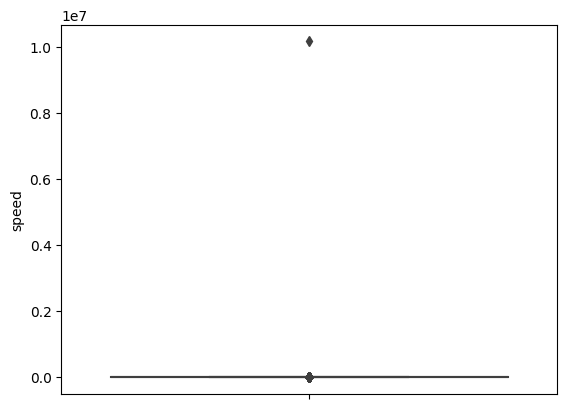

In [164]:
frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="speed", data=frame_with_durations_modified)
plt.show()

In [140]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.0
10 percentile value is 5.762845849802371
20 percentile value is 7.016949152542374
30 percentile value is 8.028545941123998
40 percentile value is 9.0
50 percentile value is 10.00162469536962
60 percentile value is 11.162790697674419
70 percentile value is 12.616314199395768
80 percentile value is 14.746987951807228
90 percentile value is 18.97271268057785
100 percentile value is 10181221.253731342


In [141]:
for i in range(90, 100):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝 쪽에 튀는 값 존재

90 percentile value is 18.97271268057785
91 percentile value is 19.69849246231156
92 percentile value is 20.526315789473685
93 percentile value is 21.483870967741932
94 percentile value is 22.59911894273128
95 percentile value is 23.904912836767036
96 percentile value is 25.492385786802032
97 percentile value is 27.490909090909096
98 percentile value is 30.237804878048784
99 percentile value is 34.413965087281795
100 percentile value is 10181221.253731342


In [142]:
for i in range(0, 11):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝쪽에 튀는 값 존재

0 percentile value is 0.0
1 percentile value is 3.221476510067114
2 percentile value is 3.8532110091743115
3 percentile value is 4.25515947467167
4 percentile value is 4.565217391304348
5 percentile value is 4.823695345557122
6 percentile value is 5.049088359046284
7 percentile value is 5.25137614678899
8 percentile value is 5.433962264150943
9 percentile value is 5.604790419161677
10 percentile value is 5.762845849802371
100 percentile value is 10181221.253731342


In [146]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is", var[-1])

99.0 percentile value is 34.413965087281795
99.1 percentile value is 34.986376021798364
99.2 percentile value is 35.61507128309572
99.3 percentile value is 36.30862329803328
99.4 percentile value is 37.052399338113624
99.5 percentile value is 37.918105574741006
99.6 percentile value is 38.9276361130255
99.7 percentile value is 40.15549385164617
99.8 percentile value is 41.723937099592305
99.9 percentile value is 44.23127463863337
100 percentile value is 10181221.253731342


In [165]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.speed>0) & (frame_with_durations_modified.speed < 50)]

In [148]:
# 평균 속도
sum(frame_with_durations_modified['speed']) / float(len(frame_with_durations_modified['speed']))

11.480535185822582

3. trip distance

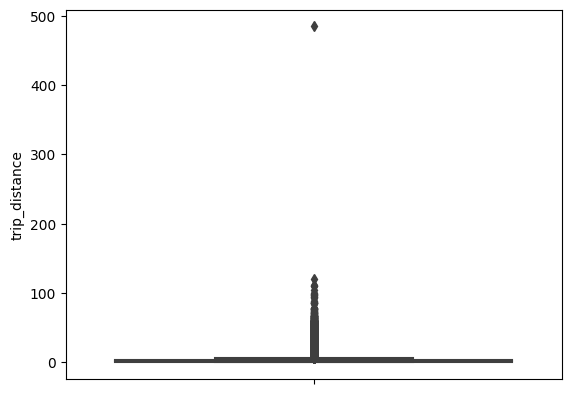

In [149]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [151]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.83
30 percentile value is 1.04
40 percentile value is 1.3
50 percentile value is 1.57
60 percentile value is 1.91
70 percentile value is 2.48
80 percentile value is 3.44
90 percentile value is 6.32
100 percentile value is 484.91


In [152]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 6.32
91 percentile value is 6.97
92 percentile value is 7.74
93 percentile value is 8.6
94 percentile value is 9.44
95 percentile value is 10.34
96 percentile value is 11.47
97 percentile value is 13.68
98 percentile value is 17.05
99 percentile value is 18.7
100 percentile value is 484.91


In [153]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.7
99.1 percentile value is 18.96
99.2 percentile value is 19.21
99.3 percentile value is 19.52
99.4 percentile value is 19.9
99.5 percentile value is 20.31
99.6 percentile value is 20.8
99.7 percentile value is 21.38
99.8 percentile value is 22.28
99.9 percentile value is 25.3
100 percentile value is  484.91


In [166]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.trip_distance>0) & (frame_with_durations_modified.trip_distance<30)]

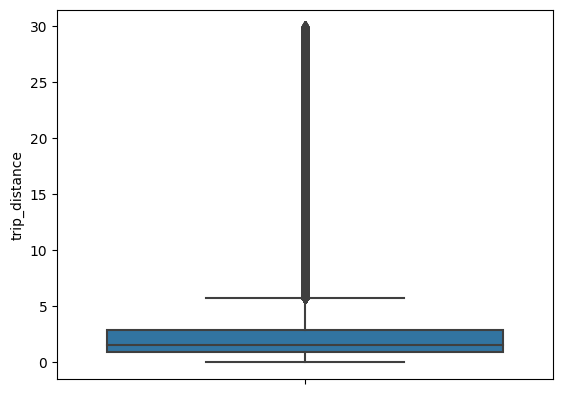

In [167]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

4. total fare

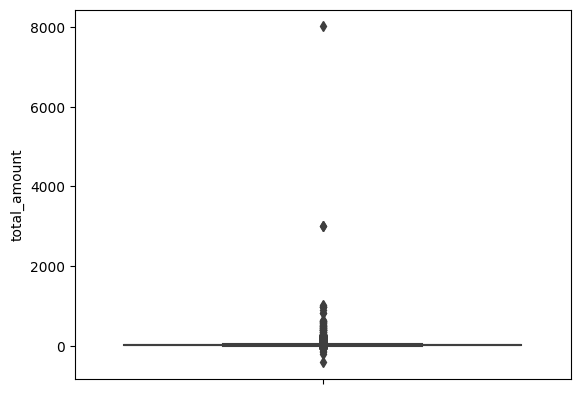

In [156]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [168]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.62
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.96
50 percentile value is 11.3
60 percentile value is 12.95
70 percentile value is 15.3
80 percentile value is 18.8
90 percentile value is 27.8
100 percentile value is  8016.8


In [169]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.24
93 percentile value is 35.56
94 percentile value is 39.3
95 percentile value is 43.06
96 percentile value is 47.56
97 percentile value is 53.47
98 percentile value is 61.55
99 percentile value is 70.26
100 percentile value is  8016.8


In [170]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.8
99.8 percentile value is 84.95
99.9 percentile value is 99.15
100 percentile value is  8016.8


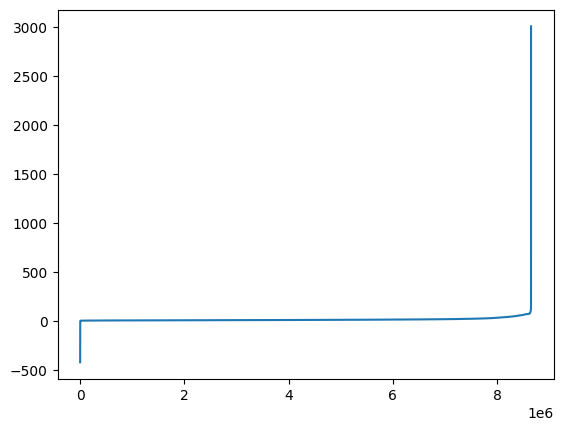

In [171]:
plt.plot(var[:-2])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

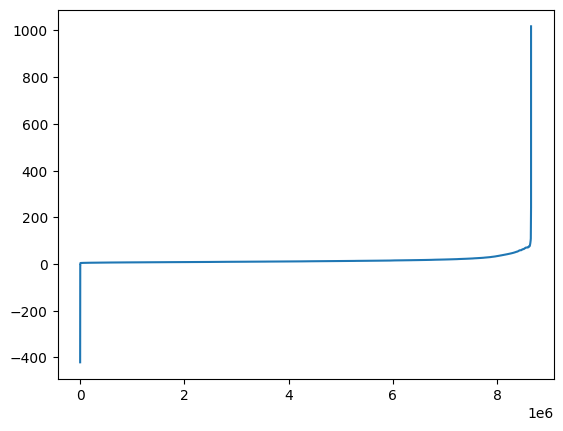

In [172]:
plt.plot(var[:-3])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

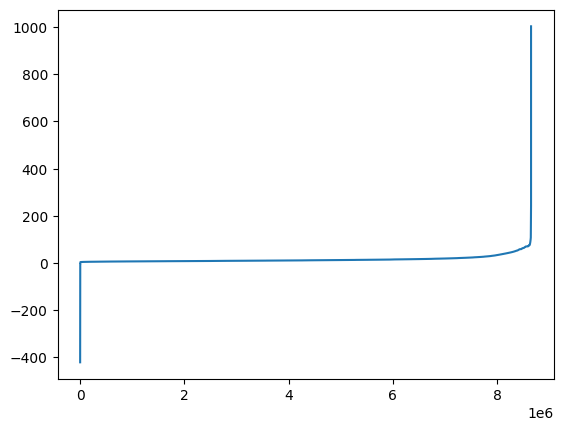

In [173]:
plt.plot(var[:-4])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

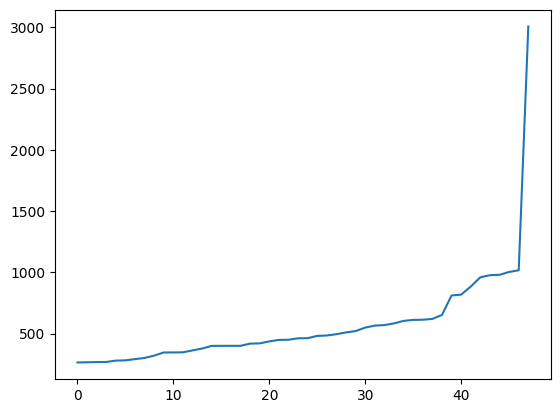

In [174]:
plt.plot(var[-50:-2])
plt.show()
# 1000언저리에서 끊어야함

5. tip_amount

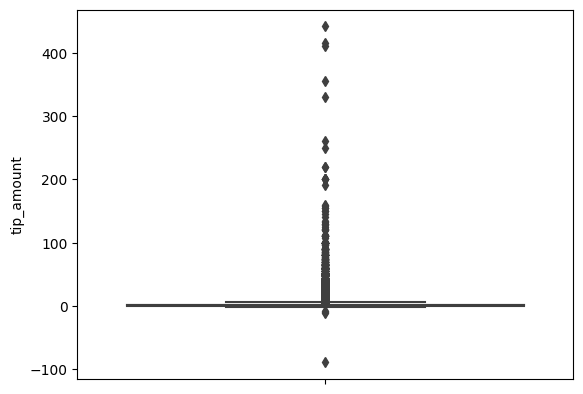

In [175]:
sns.boxplot(y="tip_amount", data =frame_with_durations_modified)
plt.show()

In [176]:
for i in range(0,100,10):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -88.8
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 1.0
50 percentile value is 1.4
60 percentile value is 1.76
70 percentile value is 2.06
80 percentile value is 2.7
90 percentile value is 3.99
100 percentile value is  441.71


In [177]:
for i in range(90,100,1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.24
93 percentile value is 35.56
94 percentile value is 39.3
95 percentile value is 43.06
96 percentile value is 47.56
97 percentile value is 53.47
98 percentile value is 61.55
99 percentile value is 70.26
100 percentile value is  8016.8


In [179]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.8
99.8 percentile value is 84.95
99.9 percentile value is 99.15
100 percentile value is  8016.8


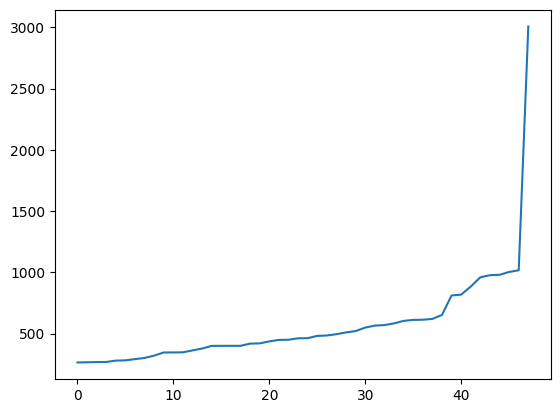

In [180]:
plt.plot(var[-50:-2])
plt.show()
# 1100언저리에서 끊어야함

In [189]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.speed <= 50) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    # 팁
    temp_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]
    f = temp_frame.shape[0]
    print ("팁 튀는 값의 개수:",(a-f))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    new_frame = new_frame[(new_frame.speed < 50) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    new_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [190]:
print("2018-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2018-01 데이터 제거 현황
---
총 데이터 수 =  8760687
시간 튀는 값의 개수: 25045
거리 튀는 값의 개수: 58699
속도 튀는 값의 개수 16996
비용 튀는 값의 개수: 5336
팁 튀는 값의 개수: 2895981
전체 삭제 된 데이터 수 2927664
---
튀는 값 제거하고 남은 비율 0.66581798893169
